In [3]:
import pandas as pd
import pm4py
import psycopg2

### Importing Data from the created XES file

In [4]:
from pm4py.objects.log.importer.xes import importer as xes_importer

#can be changed to LINE_BY_LINE for better performance
variant = xes_importer.Variants.ITERPARSE

parameters = {variant.value.Parameters.TIMESTAMP_SORT: True,
            variant.value.Parameters.MAX_TRACES: 100000}

log = xes_importer.apply('data/simple_event_log.xes', variant = variant, parameters = parameters)

parsing log, completed traces :: 100%|██████████| 11259/11259 [02:17<00:00, 81.87it/s] 


### Pandas Conversion & Selection of Assessments

In [5]:
import pm4py.objects.conversion.log.converter as converter

log_pd = converter.apply(log, variant = converter.Variants.TO_DATA_FRAME)

In [16]:
log_pd

,time:timestamp,concept:name,assessment,site,case:concept:name
0,2014-04-21,register,NaN,NaN,648183_DDD_2014J
1,2014-09-06,interact,NaN,814218.0,648183_DDD_2014J
2,2014-09-06,interact,NaN,813701.0,648183_DDD_2014J
3,2014-09-06,interact,NaN,813936.0,648183_DDD_2014J
4,2014-09-06,interact,NaN,813933.0,648183_DDD_2014J
...,...,...,...,...,...
3686611,2015-02-20,interact,NaN,883169.0,357851_FFF_2014J
3686612,2015-02-20,interact,NaN,882545.0,357851_FFF_2014J
3686613,2015-02-20,interact,NaN,882537.0,357851_FFF_2014J
3686614,2015-02-20,interact,NaN,941543.0,357851_FFF_2014J


In [7]:
assess = log_pd [log_pd['concept:name'] == 'submitAssessment']

In [8]:
assess = assess[['case:concept:name','assessment']]

In [9]:
assess.rename(columns={"assessment":"id_assessment"},inplace=True)

In [10]:
id_dummy=[]
for i,row in assess.iterrows():
    id_dummy.append(row.loc["case:concept:name"][:6])
assess["id_student"] = id_dummy

### Connect to PostgreSQL

In [11]:
query = """

SELECT DISTINCT
	registration.code_module,
	assessments.code_presentation,
	student_assessment.id_student,
	assessments.id_assessment,
	assessments.weight,
	student_assessment.score,
	registration.date_unregistration as still_enrolled
	
FROM student_assessment

JOIN assessments ON student_assessment.id_assessment = assessments.id_assessment

LEFT JOIN registration ON student_assessment.id_student = registration.id_student

WHERE assessments.code_presentation = '2014J' OR assessments.code_presentation = '2014B'

"""

In [89]:
from psycopg2 import Error

try:
    # Connect to an existing database
    connection = psycopg2.connect(user="postgres",
                                  password="thesis1",
                                  host="localhost",
                                  port="5433",
                                  database="OULAD")

    # Create a cursor to perform database operations
    cursor = connection.cursor()
    # Executing a SQL query
    cursor.execute("SELECT version();")
    # Fetch result
    record = cursor.fetchone()
    print("You are connected to - ", record, "\n")

    #getting the SQL info
    cursor.execute(query)
    grades = cursor.fetchall()


except (Exception, Error) as error:
    print("Error while connecting to PostgreSQL", error)
finally:
    if (connection):
        cursor.close()
        connection.close()
        print("PostgreSQL connection is closed")

You are connected to -  ('PostgreSQL 14.2, compiled by Visual C++ build 1914, 64-bit',) 

PostgreSQL connection is closed


In [90]:
# comes as tuples and needs to be converted to pd
grades = pd.DataFrame(grades, columns = ["code_module","code_presentation","id_student","id_assessment","weight","score","still_enrolled"])
grades["id_assessment"]=pd.to_numeric(grades["id_assessment"])

In [91]:
#creating a column mimicking the case:concept:name identifier
def case_id (row, info):
    id= ''
    for i in info:
        id = id +'_'+ str(row[i])
    return id[1:]
keys = ["id_student", "code_module", "code_presentation"]

dummy=[]
for i,rows in grades.iterrows():
    #creating the case_id
    dummy.append ( case_id(rows, keys) )

grades["case:concept:name"] = dummy

In [92]:
grades["score"] = grades["score"]*grades["weight"]/100
grades.drop(["code_module","code_presentation","id_student","weight","id_assessment"],axis=1, inplace = True)
grades = grades[["case:concept:name","score","still_enrolled"]]
grades.reset_index(drop=True,inplace=True)

In [93]:
pd.options.mode.chained_assignment = None

grades["count"] = grades["case:concept:name"].copy()

In [94]:
grades

,case:concept:name,score,still_enrolled,count
0,614745_BBB_2014B,3.25,True,614745_BBB_2014B
1,691286_BBB_2014J,0.00,False,691286_BBB_2014J
2,560117_BBB_2014B,1.98,False,560117_BBB_2014B
3,609403_GGG_2014J,12.40,True,609403_GGG_2014J
4,640225_BBB_2014J,12.80,True,640225_BBB_2014J
...,...,...,...,...
107596,626296_CCC_2014J,18.92,True,626296_CCC_2014J
107597,67781_DDD_2014B,13.00,True,67781_DDD_2014B
107598,561848_CCC_2014J,1.56,True,561848_CCC_2014J
107599,577460_EEE_2014B,25.20,True,577460_EEE_2014B


In [95]:
#individual example journey
grades[grades["case:concept:name"] == '104772_DDD_2014J']

,case:concept:name,score,still_enrolled,count
38159,104772_DDD_2014J,19.75,True,104772_DDD_2014J
41032,104772_DDD_2014J,18.75,True,104772_DDD_2014J
43868,104772_DDD_2014J,5.60,True,104772_DDD_2014J
64995,104772_DDD_2014J,3.35,True,104772_DDD_2014J
72536,104772_DDD_2014J,19.75,False,104772_DDD_2014J
75857,104772_DDD_2014J,5.60,False,104772_DDD_2014J
85874,104772_DDD_2014J,3.35,False,104772_DDD_2014J
89130,104772_DDD_2014J,18.75,False,104772_DDD_2014J
94133,104772_DDD_2014J,5.60,False,104772_DDD_2014J
98596,104772_DDD_2014J,5.60,True,104772_DDD_2014J


### Grouping by case:concept:name for grades/course
Final output has to be a dataframe with a student id and the grade that student has obtained, as well as a boolean value saying if the student dropped or not

In [96]:
grades = grades.groupby(["case:concept:name"]).agg({ "score":"sum",
                                                     "still_enrolled":"sum",
                                                     "count": "count" })


In [97]:
still_enrolled = []
for i,rows in grades.iterrows() :
    if rows["still_enrolled"] == rows["count"]:
        still_enrolled.append(True)
    else: still_enrolled.append(False)
grades["still_enrolled"] = still_enrolled


In [99]:
grades.reset_index(inplace = True)
grades.drop("count",axis=1, inplace = True)

### Adding the rule for passing students (positive trace)
Hypothesis -> a student needs to have more than 40% overall

But we could also consider an assignment passed if he gets more than 40% -> and than we can add all assignment weights to 100

In [101]:
passed_course = grades["case:concept:name"].where( (grades["score"]>=40) & 
                                                    (grades["still_enrolled"] == True) ).dropna()
passed_course = list(passed_course)

In [103]:
log_pd["case:concept:name"].nunique()

11259

### Splitting the Event Log
Done by double filtering

Using the boolean to keep / remove values?

In [105]:
log_positive = pm4py.filter_event_attribute_values(log, attribute_key="case:concept:name", values = passed_course, retain=True, level = "case")

In [108]:
log_negative = pm4py.filter_event_attribute_values(log, attribute_key="case:concept:name", values = passed_course, retain=False, level = "case")

In [109]:
print(len(log_positive),len(log_negative))

5221 6038


## DFG GRAPHS

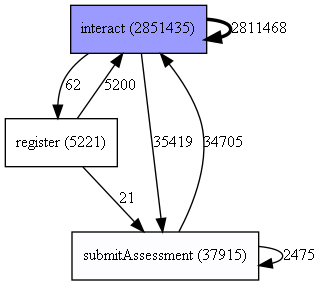

In [118]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(log_positive)

from pm4py.visualization.dfg import visualizer as dfg_visualization
gviz = dfg_visualization.apply(dfg, log=log_positive, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)
dfg_visualization.save(gviz, "dfg_positive.png")



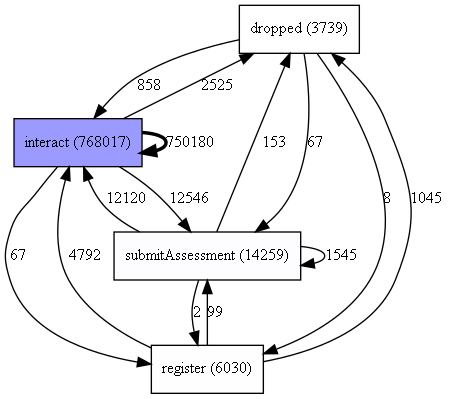

In [119]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
dfg = dfg_discovery.apply(log_negative)

from pm4py.visualization.dfg import visualizer as dfg_visualization
gviz = dfg_visualization.apply(dfg, log=log_negative, variant=dfg_visualization.Variants.FREQUENCY)
dfg_visualization.view(gviz)
dfg_visualization.save(gviz, "dfg_negative.png")


## Heuristic Net

In [120]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
heu_net = heuristics_miner.apply_heu(log, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})

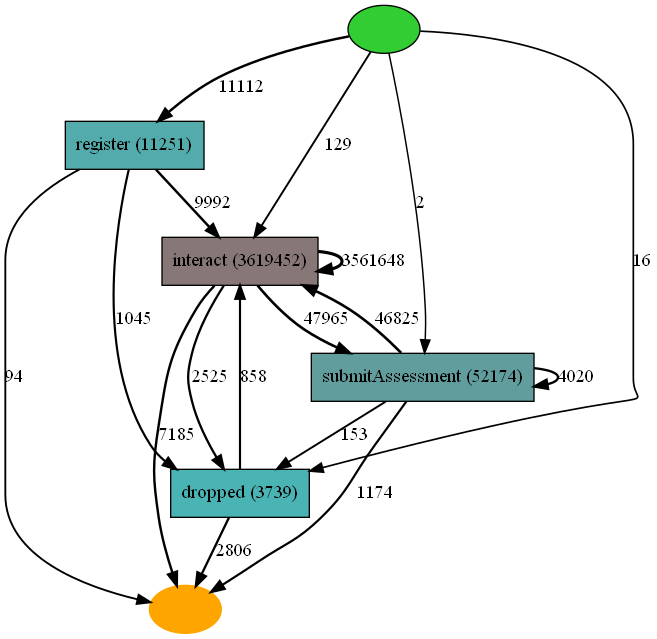

In [121]:
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)
hn_visualizer.save(gviz, "hn_all.png")


In [122]:
heu_net = heuristics_miner.apply_heu(log_positive, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})

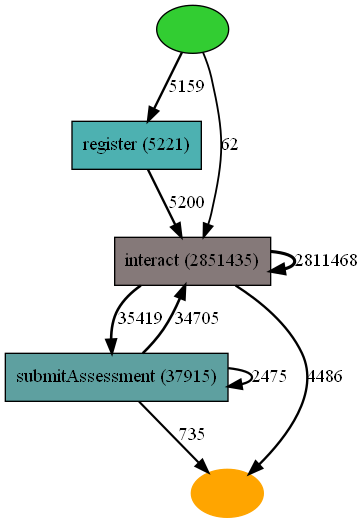

In [123]:
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)
hn_visualizer.save(gviz, "hn_positive.png")


In [124]:
heu_net = heuristics_miner.apply_heu(log_negative, parameters={heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.99})

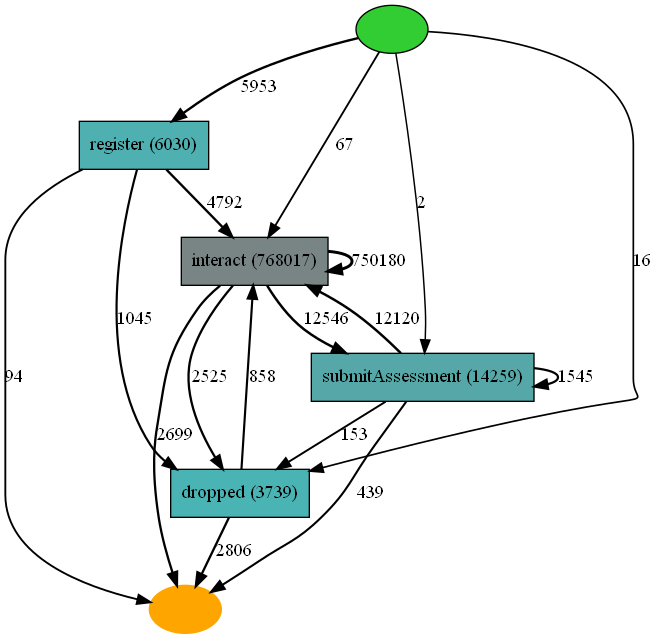

In [125]:
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)
hn_visualizer.save(gviz, "hn_negative.png")
